Multiclass Classification Keras with ResNet50

In [1]:
#Importing required libraries and functions

from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import os
import keras.backend as K
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#Function for extracted only required classes on which model is tobe trained
'''
filepath: path of txt file which is reference for train test splitting
food_list: list of classes names on which the the model is to be trained
src: path of the directory where images are stored
dest: destination path where the data is to be extracted for the model to be fed on
'''

def prepare_data(filepath, food_list, src, dest):
  classes_images = defaultdict(list) #using defaultlist to give output an empty list whenever a unknown key is used
  with open(filepath, 'r') as txt: #opening text file for train test reference
      paths = [read.strip() for read in txt.readlines()] #creating a list of all the paths present in the txt file
      for p in paths: #iterating for each file path
        food = p.split('/') #splitting the path in two, at 0: class of food, at 1: image name
        classes_images[food[0]].append(food[1] + '.jpg') #storing the list of all the files related to a single food class, where food class is the key of the dictionary and list of files is the value

  for food in food_list: #extracting and storing only those which are required and mentioned
    print("\nCopying images into ",food) #mentioning the food class to which copying is happinging currently
    if not os.path.exists(os.path.join(dest,food)): #if path with food classes don't exists
      os.makedirs(os.path.join(dest,food))          #creating one, to avoid any errors
    for i in classes_images[food]: #iteration through the list of files related to single food class
      copy(os.path.join(src,food,i), os.path.join(dest,food,i)) #copying all the files
  print("Done!")

In [3]:
#Extracting data
food_list = ['apple_pie','donuts','chocolate_cake']
prepare_data('/kaggle/input/food-101/food-101/meta/train.txt', food_list, '/kaggle/input/food-101/food-101/images', 'train_mini') #for training data
prepare_data('/kaggle/input/food-101/food-101/meta/test.txt', food_list, '/kaggle/input/food-101/food-101/images', 'test_mini') #for validation data


Copying images into  apple_pie

Copying images into  donuts

Copying images into  chocolate_cake
Done!

Copying images into  apple_pie

Copying images into  donuts

Copying images into  chocolate_cake
Done!


In [4]:
n_classes = len(food_list) #total number of classes for classification
img_width, img_height = 300, 300 #image size to be fed in model
train_dir = 'train_mini' #path for training data
validation_dir = 'test_mini' #path for validation data
nb_train_samples = sum([len(files) for r, d, files in os.walk("train_mini")]) #total number of items present in training data as a whole
nb_validation_samples = sum([len(files) for r, d, files in os.walk("test_mini")]) #total number of items present in validation data as a whole
batch_size = 8 #batch size of the model

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=10, horizontal_flip=True) #training image data generator

test_datagen = ImageDataGenerator(rescale=1./255)#validation image data generator

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical') #fetching data from directory for training generator

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical') #fetching data from directory for validation generator


res = ResNet50(include_top = False, input_shape = [img_height, img_width, 3], weights = 'imagenet') #Initializing ResNet50 pretrained model

X = Flatten()(res.output) #adding a Flatten layer after the re
X = Dense(256, activation='relu')(X) #Adding Dense Layer
X = Dropout(0.2)(X) #Adding Dropout
X = Dense(512, activation='relu')(X) #Adding another Dense Layer
X = Dropout(0.2)(X) #Adding Dropout
X = Dense(256, activation='relu')(X) #Adding another Dense Layer
X = Dropout(0.2)(X) #Adding Dropout
pred = Dense(n_classes, activation='softmax')(X) #final layer of the model having number of nodes equal to the number of classification categories to be used


model = Model(inputs = res.input, outputs = pred) #instantiating model

model.summary() #printing model summary, gives information about the structure of model

model.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #compiling model for configuring loss optimizer and metric
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True) #saving the model after each epoch if validation loss improves
csv_logger = CSVLogger('history_3class.log') #Kepping the log of model training for each epoch

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=15,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer]) #fitting the model

model.save('model_trained_3class.hdf5') #saving model after last epoch, doesn't matter if validation loss improves from best loss or not in last epoch.

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________

In [5]:
class_map = train_generator.class_indices #getting class mapping with respect to the prediction of the model
class_map = list(class_map.keys())
class_map

['apple_pie', 'chocolate_cake', 'donuts']

In [6]:
#clearing session for faster processing and loading the model with best result
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

In [7]:
#function to predict and plot the images with their class name
'''
model: model which will be used for predictions
images: a 2D list storing all the images to be predicted
'''
def predict_class(model, images):
  for img in images: #iterating over each image in 'images'
    img = load_img(img, target_size=(300, 300)) #loading image and resizing it as per the model
    img = img_to_array(img) #converting it to array              
    img = np.expand_dims(img, axis=0) #using expand_dims to format image array to be ready to be fed in model, as model takes batches as input      
    img /= 255. #normalizing the data for reducing the computation load on the system

    pred = model.predict(img) #getting a prediction for the image
    index = np.argmax(pred) #returns the index of the maximum value in array/list, finding the class to which image is most likely to be from
    pred_value = class_map[index] #getting prediction as per the index found
    #displaying image and predicted value
    plt.imshow(img[0])                           
    plt.axis('off')
    plt.title(pred_value)
    plt.show()

In [8]:
#downloading and saving the images for testing model for prediction on new data
!wget -O chocolate_cake.jpg https://food-images.files.bbci.co.uk/food/recipes/easy_chocolate_cake_31070_16x9.jpg
!wget -O apple_pie.jpg https://lexiscleankitchen.com/wp-content/uploads/2018/07/Paleo-Apple-Pie.jpg
!wget -O donut.jpg https://www.christinascucina.com/wp-content/uploads/2014/01/IMG_4471-720x540.jpg

--2020-06-20 15:26:56--  https://food-images.files.bbci.co.uk/food/recipes/easy_chocolate_cake_31070_16x9.jpg
Resolving food-images.files.bbci.co.uk (food-images.files.bbci.co.uk)... 23.42.95.131, 2600:1406:e800:79a::f33, 2600:1406:e800:79f::f33
Connecting to food-images.files.bbci.co.uk (food-images.files.bbci.co.uk)|23.42.95.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197844 (193K) [image/jpeg]
Saving to: ‘chocolate_cake.jpg’

chocolate_cake.jpg  100%[===================>] 193.21K  --.-KB/s    in 0.1s    

2020-06-20 15:26:57 (1.61 MB/s) - ‘chocolate_cake.jpg’ saved [197844/197844]

--2020-06-20 15:26:58--  https://lexiscleankitchen.com/wp-content/uploads/2018/07/Paleo-Apple-Pie.jpg
Resolving lexiscleankitchen.com (lexiscleankitchen.com)... 151.101.66.159
Connecting to lexiscleankitchen.com (lexiscleankitchen.com)|151.101.66.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 828956 (810K) [image/jpeg]
Saving to: ‘apple_pie.

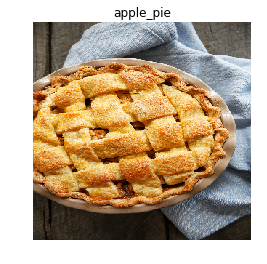

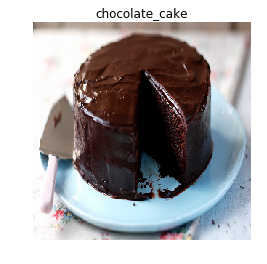

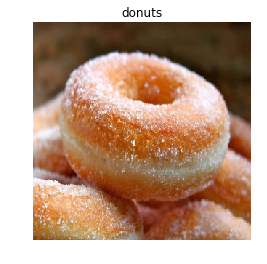

In [9]:
images = [] #empty list
#appending the required 
images.append('apple_pie.jpg')
images.append('chocolate_cake.jpg')
images.append('donut.jpg')

#calling the function for prediction and displaying the images with predicted class
predict_class(model_best, images)